In [1]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt
import bitstring
from qiskit_aer import AerSimulator

from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

from qiskit.circuit.library import UnitaryGate

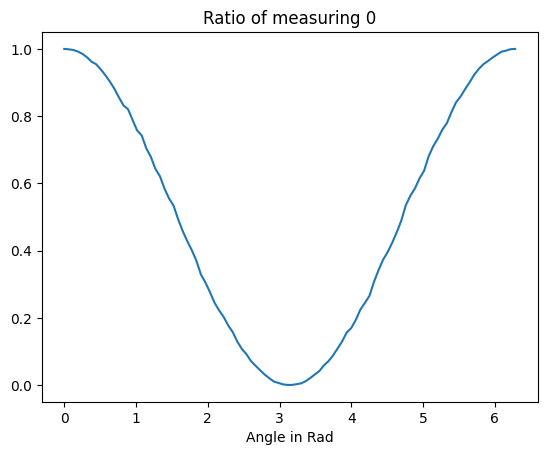

In [21]:
qr = QuantumRegister(1)

qc = QuantumCircuit(qr)

angles = np.linspace(0,2*np.pi,100)

p = []

shots = 10000

for i in angles:
    qc = QuantumCircuit(qr)

    qc.h(0)
    qc.p(i,0)
    qc.h(0)

    qc.measure_all()

    sim = AerSimulator()
    job = sim.run(qc, shots=shots)
    result = job.result()
    counts = result.get_counts()

    if "0" in counts:
        p.append(counts["0"]/shots)
    else:
        p.append(0)

plt.plot(angles,p)
plt.title("Ratio of measuring 0")
plt.xlabel("Angle in Rad")
plt.show()

#qc.draw("mpl")

In [ ]:
def closest_bin(n: float, prec: int):           #Gibt einem den nächsten binären Nachbarn zu einem Float an bei gegebener Präzision/Depth
    closest = 10
    steps = 2**(-prec)
    bin_list = [i*steps for i in range(2**prec+1)]
    for i in bin_list:
        if np.abs(n - i) < np.abs(closest-n):
            closest = i
    return closest

def convert(bin: str):                  #konvertiert den bitstring in deciaml, e.g. 0110 = 0.375
    k = list(bin)
    a = [int(i) for i in k]
    n = 0
    for i in range(len(a)):
        if a[i] == 1:
            n += 1/2**(i+1)
    return n

def skill(phi: float, shots:int, error: float):

    p = error
    p_error = pauli_error([["X",p/2],["I",1-p],["Z",p/2]])
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(p_error, ['h', "p"])  # Apply to single-qubit gates

    angle = 2*np.pi*phi
    qr = QuantumRegister(1)
    qc = QuantumCircuit(qr)

    qc.h(0)
    qc.p(angle,0)
    qc.h(0)
    qc.measure_all()

    sim = AerSimulator()
    job = sim.run(qc, noise_model=noise_model,shots=shots)
    result = job.result()
    counts = result.get_counts()

    p = 0

    if "0" in counts:
        p = counts["0"]/shots
    else:
        return 0.5

    hmm_1 = np.arccos(2*p-1)
    hmm_2 = 2*np.pi-hmm_1

    qr = QuantumRegister(1)
    qc = QuantumCircuit(qr)

    qc.h(0)
    qc.p(angle,0)
    qc.p(-hmm_1,0)
    qc.h(0)
    qc.measure_all()

    #confidence = 0.5*(1+np.cos(angle-hmm_1))

    sim = AerSimulator()
    job = sim.run(qc, noise_model=noise_model, shots=shots)
    result = job.result()
    counts = result.get_counts()

    if "0" in counts:
        if counts["0"] >= shots*0.999:
            return hmm_1/(2*np.pi)
        else:
            return hmm_2/(2*np.pi)
    else:
        return 0.75
    
def nxt_lvl(phi:float, shots:int, error: float, idk: int):
    first = skill(phi,shots,error)
    print("Erstes Ergebnis für phi: ", first)
    print("Abweichung = ", np.abs(phi-first))
    bitstring_1 = closest_bin(first, idk)

    new_phi = phi*(2**idk)
    second= skill(new_phi, shots, error)
    bitstring_2 = closest_bin(second, idk)*(2**(-idk))
    result = bitstring_1+bitstring_2
    print("Neues Ergebnis: ", result)
    print("Abweichung = ", np.abs(phi-result))
    print("Verbesserung um den Faktor ", np.abs(phi-first)/np.abs(phi-result))
    return result

def prec_per_shots(phi:float, maxshots: int, steps:int ,error:float):
    shots = np.linspace(0,maxshots, steps)
    for i in shots:
        y_i = skill()

0.00044304521962492614


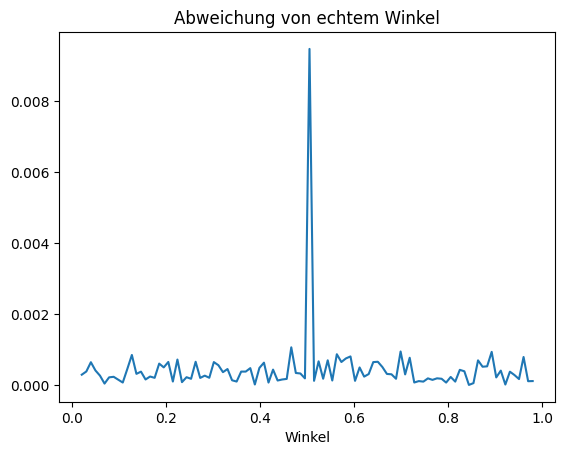

In [198]:
all = np.linspace(0.02,0.98,100)

y = []

for i in all:
    run = skill(i,100000,0)
    yes = np.abs(run-i)
    y.append(yes)

plt.plot(all,y)
plt.title("Abweichung von echtem Winkel")
plt.xlabel("Winkel")
#plt.yscale("log")
print(np.mean(y))

In [196]:
nxt_lvl(0.3, 100000, 0, 7)

Erstes Ergebnis für phi:  0.29950206592872236
Abweichung =  0.0004979340712776281
Neues Ergebnis:  0.29998779296875
Abweichung =  1.2207031249988898e-05
Verbesserung um den Faktor  40.79075911910039


0.29998779296875